# 1. SETUP

  Install required text processing libraries for the example

In [1]:
#!pip install nltk

import nltk

nltk.download("stopwords")
nltk.download("punkt")

from nltk.corpus import stopwords

nltk.download("wordnet")
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yalci\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\yalci\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\yalci\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# 2. CREATİNG TEXT REPRESANTATİON

 Text data needs to be converted to numeric representation before they can be used to train deep learning models. The Spam classification feature data is converted to TF-IDF vextors and the target variable is converted to one-hot-encoding.

In [2]:
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale

In [3]:
#Load Spam Data and review content
spam_data = pd.read_csv("Spam-Classification.csv")

spam_data.head()

,CLASS,SMS
0,ham,"said kiss, kiss, i can't do the sound effects..."
1,ham,&lt;#&gt; ISH MINUTES WAS 5 MINUTES AGO. WTF.
2,spam,(Bank of Granite issues Strong-Buy) EXPLOSIVE ...
3,spam,* FREE* POLYPHONIC RINGTONE Text SUPER to 8713...
4,spam,**FREE MESSAGE**Thanks for using the Auction S...


In [4]:
# Seperate feature and target data
spam_classes_raw = spam_data["CLASS"]

spam_messages = spam_data["SMS"]
print("------TARGET DATA-----------")
print(spam_classes_raw.head())
print("-----FEATURE DATA-----------")
print(spam_messages.head())

------TARGET DATA-----------
0     ham
1     ham
2    spam
3    spam
4    spam
Name: CLASS, dtype: object
-----FEATURE DATA-----------
0     said kiss, kiss, i can't do the sound effects...
1        &lt;#&gt; ISH MINUTES WAS 5 MINUTES AGO. WTF.
2    (Bank of Granite issues Strong-Buy) EXPLOSIVE ...
3    * FREE* POLYPHONIC RINGTONE Text SUPER to 8713...
4    **FREE MESSAGE**Thanks for using the Auction S...
Name: SMS, dtype: object


In [5]:
import nltk
import tensorflow as tf

# Custom tokenizer to remove stopwords and use lemmatization
def customtokenize(str):
    # 1. Split string as tokens
    tokens = nltk.word_tokenize(str) #string olarak verilen metinleri kelimelere(tokens) ayırır.
    
    # 2. Filter for stopwords
    nostop = list(filter(lambda token: token not in stopwords.words("english"), tokens))
    # yukarıdaki "stopwords.words("english")" bloğu ingilizce önemsiz kelime(stopword) listesini alır
    # filter fonksiyonu, tokens listesindeki her bir kelimeyi (token) kontrol eder ve bu kelime stopword-
    #listesinde değilse, bu kelimeyi nostop listesine ekler.
    # lambda token: token not in stopwords.words("english"), token'ların stopword listesinde-
    #olup olmadığını kontrol eden anonim bir fonksiyondur.
    # list fonksiyonu, filter sonucunu listeye çevirir.
    
    # 3. Perform lemmatization
    lemmatized = [lemmatizer.lemmatize(word) for word in nostop]
    # lemmatizer.lemmatize(word), her kelimenin kök halini bulur.
    # nostop listesindeki her kelime için bu işlem yapılır ve sonuçlar lemmatized listesine eklenir.
    # Lemmatization, kelimelerin temel formunu bulur. Örneğin, "running" kelimesi "run" olarak lemmatize edilir.
    return lemmatized

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer 
# Br üstteki kod, metin verilerini sayısal özellik vektörlerine dönüştürmek için kullanılır

# Build a TF-IDF Vectorizer model
vectorizer = TfidfVectorizer(tokenizer=customtokenize)

# Transform feature input to TF-IDF
tfidf = vectorizer.fit_transform(spam_messages)

# Convert TF-IDF to numpy array
tfidf_array = tfidf.toarray()

C:\Users\yalci\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [7]:
# Build a label encoder for target variable to convert strings to numeric values.
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
spam_classes = label_encoder.fit_transform(spam_classes_raw)

# Convert target to one-hot-encoding vector
spam_classes = tf.keras.utils.to_categorical(spam_classes,2) # 2 farklı target sonucumuz var (spam, ham)

print("TF-IDF Matrix Shape : ", tfidf.shape)
print("One-hot Encoding Shape : ", spam_classes.shape)

x_train, x_test, y_train, y_test = train_test_split (tfidf_array, spam_classes, test_size=0.10)

TF-IDF Matrix Shape :  (1500, 4566)
One-hot Encoding Shape :  (1500, 2)


# 3. Building and Evaluating Model

In [8]:
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.regularizers import l2

In [9]:
# Setup Hyper Parameters for building the model
NB_CLASSES = 2 # There are 2 clasess (ham and spam), that's about target variabe.
N_HIDDEN = 32

In [10]:
model = tf.keras.Sequential()

In [11]:
# Add the first hidden layer
model.add(keras.layers.Dense(N_HIDDEN,
                             input_shape = (x_train.shape[1],), # bu satır önemli!!
                             name="Hidden-Layer-1",
                             activation="relu"))

In [12]:
# Add the second hidden layer
model.add(keras.layers.Dense(N_HIDDEN,
                             name="Hidden-Layer-2",
                             activation="relu"))

In [13]:
# Add an Output layer with softmax activation ( softmax activation çok sınıflı sınıflandırmada kulanılır)
# Add an Output layer with softmax activation ( softmax activation çok sınıflı sınıflandırmada kulanılır)
model.add(keras.layers.Dense(NB_CLASSES,
                             name = "Output-Layer",
                             activation = "softmax"))

In [14]:
# Compile the model with loss & metrics
model.compile(loss="categorical_crossentropy",
              metrics = ["accuracy"])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden-Layer-1 (Dense)      (None, 32)                146144    
                                                                 
 Hidden-Layer-2 (Dense)      (None, 32)                1056      
                                                                 
 Output-Layer (Dense)        (None, 2)                 66        
                                                                 
Total params: 147266 (575.26 KB)
Trainable params: 147266 (575.26 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# 4. Training and Evaluating the Model
Training the odel involves defining training models and then perform forward and back propagation

In [16]:
VERBOSE = 1

# Setup Hyper Parameters for training
BATCH_SIZE = 256
EPOCHS=10
VALIDATION_SPLIT=0.2

In [17]:
print("\nEğitim İlerlemesi:\n------------------------------------")

# Fit the model. This will perform the entire training cycle, including
# forward propagation, loss computation, backward propagation and gradient descent.
# Execute for the specified batch size and epoch
# Perform validation after each epoch
history = model.fit(x_train,
                    y_train,
                    batch_size = BATCH_SIZE,
                    epochs= EPOCHS,
                    verbose = VERBOSE,
                    validation_split = VALIDATION_SPLIT)


Eğitim İlerlemesi:
------------------------------------
Epoch 1/10


5/5 [==============================] - 2s 101ms/step - loss: 0.6898 - accuracy: 0.6074 - val_loss: 0.6803 - val_accuracy: 0.8296
Epoch 2/10
5/5 [==============================] - 0s 20ms/step - loss: 0.6700 - accuracy: 0.8620 - val_loss: 0.6558 - val_accuracy: 0.8852
Epoch 3/10
5/5 [==============================] - 0s 19ms/step - loss: 0.6360 - accuracy: 0.9296 - val_loss: 0.6213 - val_accuracy: 0.9185
Epoch 4/10
5/5 [==============================] - 0s 17ms/step - loss: 0.5918 - accuracy: 0.9593 - val_loss: 0.5823 - val_accuracy: 0.9370
Epoch 5/10
5/5 [==============================] - 0s 17ms/step - loss: 0.5426 - accuracy: 0.9667 - val_loss: 0.5411 - val_accuracy: 0.9222
Epoch 6/10
5/5 [==============================] - 0s 17ms/step - loss: 0.4916 - accuracy: 0.9685 - val_loss: 0.5002 - val_accuracy: 0.9444
Epoch 7/10
5/5 [==============================] - 0s 18ms/step - loss: 0.4411 - accuracy: 0.9796 - val_los


Eğitim Sırasında Doğruluk :
------------------------------------


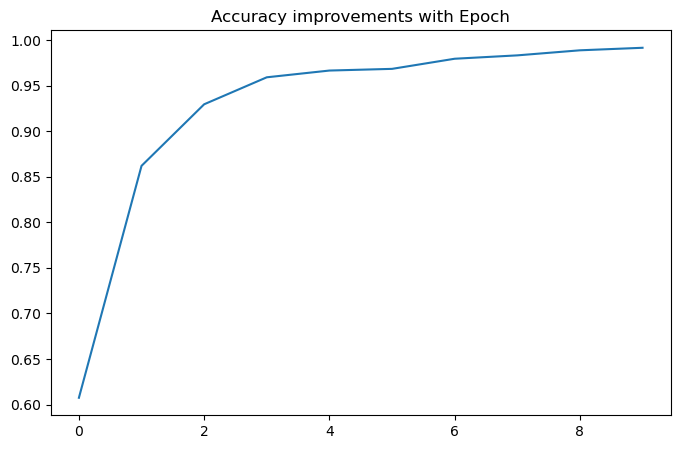


Test Veri Kümesine Karşı Değerlendirme :
------------------------------------
5/5 [==============================] - 0s 12ms/step - loss: 0.3720 - accuracy: 0.9400


[0.37202247977256775, 0.9399999976158142]

In [18]:
print("\nEğitim Sırasında Doğruluk :\n------------------------------------")

import matplotlib.pyplot as plt

# plot accuracy of the model after each epoch.
pd.DataFrame(history.history)["accuracy"].plot(figsize=(8,5))
plt.title("Accuracy improvements with Epoch")
plt.show()

# Evaluate the model against the test dataset and print results
print("\nTest Veri Kümesine Karşı Değerlendirme :\n------------------------------------")
model.evaluate(x_test,y_test)

# 4. Predicting for Text

In [19]:
# Predict for multiple sample using batch processing

# Convert input into TF-IDF vector using the same vectorizer model
predict_tfidf=vectorizer.transform(["FREE entry to a fun contest",
                                    "Yup I will come over"]).toarray()
print(predict_tfidf.shape)

# Predict using model
prediction = np.argmax(model.predict(predict_tfidf), axis=1)
print("Prediction Output: ", prediction)

# Print prediciton classes
print("Prediction Classes are ", label_encoder.inverse_transform(prediction))

(2, 4566)
1/1 [==============================] - 0s 143ms/step
Prediction Output:  [1 0]
Prediction Classes are  ['spam' 'ham']


In [20]:
# Predict for multiple sample using batch processing

# Convert input into TF-IDF vector using the same vectorizer model
predict1_tfidf=vectorizer.transform(["Hİ, what's up bro"]).toarray()
print(predict1_tfidf.shape)

# Predict using model
prediction1 = np.argmax(model.predict(predict1_tfidf), axis=1)
print("Prediction Output: ", prediction1)

# Print prediciton classes
print("Prediction Classes are ", label_encoder.inverse_transform(prediction1))

(1, 4566)
1/1 [==============================] - 0s 37ms/step
Prediction Output:  [0]
Prediction Classes are  ['ham']
